# Imports/Set up

In [4]:
# Specific to NERSC: Set up kernel using: https://docs.nersc.gov/services/jupyter/how-to-guides/
from __future__ import annotations

import sys

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from neuralop import H1Loss
from neuralop import LpLoss
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.utils import count_model_params
from neuralop.utils import get_project_root
from torch.utils.data import DataLoader

root_dir = get_project_root() / 'neuralop/data/datasets/data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

device=device(type='cuda')


In [5]:
# first download data
data = DarcyDataset(
    root_dir=root_dir,
    n_train=100,
    n_tests=[32, 32, 32, 32],
    batch_size=16,
    test_batch_sizes=[16, 16, 16, 16],
    train_resolution=128,  # change resolution to download different data
    test_resolutions=[16, 32, 64, 128],
)

Loading test db for resolution 16 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 64 with 32 samples 
Loading test db for resolution 128 with 32 samples 


In [6]:
# load darcy flow dataset


def load_darcy_flow_small(
    n_train,
    n_tests,
    data_root=root_dir,
    test_resolutions=(16, 32),
    train_resolution=16,
):
    """Docstring."""
    batch_size = 16
    test_batch_sizes = [batch_size] * len(test_resolutions)

    dataset = DarcyDataset(
        root_dir=data_root,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=False,
        encode_output=True,
        channel_dim=1,
        encoding='channel-wise',
        download=True,
    )

    # return dataloaders for backwards compat
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        persistent_workers=False,
    )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor

In [7]:
df = pd.DataFrame(
    columns=['train_resolution', 'test_resolution', 'loss_type', 'loss'],
)

for train_resolution in [16, 32, 64, 128]:
    # get data
    train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000,
        # batch_size=16,
        train_resolution=train_resolution,
        test_resolutions=[16, 32, 64, 128],
        n_tests=[100, 100, 100, 100],
        # test_batch_sizes=[32, 32, 32, 32],
    )

    # incrementally vary modes
    incremental = True
    starting_modes = (16, 16)
    if incremental:
        starting_modes = (2, 2)

    # Set up model
    model = FNO(
        max_n_modes=(16, 16),
        n_modes=starting_modes,
        hidden_channels=32,
        in_channels=1,
        out_channels=1,
    )
    model = model.to(device)
    n_params = count_model_params(model)

    # optimizer + data
    optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    data_transform = IncrementalDataProcessor(
        in_normalizer=None,
        out_normalizer=None,
        device=device,
        subsampling_rates=[2, 1],
        dataset_resolution=16,
        dataset_indices=[2, 3],
        epoch_gap=10,
        verbose=True,
    )

    data_transform = data_transform.to(device)

    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    train_loss = h1loss
    eval_losses = {'h1': h1loss, 'l2': l2loss}
    print('\n### N PARAMS ###\n', n_params)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print('\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    sys.stdout.flush()

    # Finally pass all of these to the Trainer
    trainer = IncrementalFNOTrainer(
        model=model,
        n_epochs=20,
        data_processor=data_transform,
        device=device,
        verbose=False,
        incremental_loss_gap=False,
        incremental_grad=True,
        incremental_grad_eps=0.9999,
        incremental_loss_eps=0.001,
        incremental_buffer=5,
        incremental_max_iter=1,
        incremental_grad_max_iter=2,
    )

    # train
    end_stats = trainer.train(
        train_loader,
        test_loaders,
        optimizer,
        scheduler,
        regularizer=False,
        training_loss=train_loss,
        eval_losses=eval_losses,
    )

    # save stats
    for k, v in end_stats.items():
        s = k.split('_')

        if 'h1' in s or ('l2' in s):
            row = {
                'train_resolution': train_resolution,
                'test_resolution': s[0],
                'loss_type': s[1],
                'loss': v.item(),
            }
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f635a575060>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f635a575060>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f635a576500>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16


/tmp/ipykernel_2292371/3641991373.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f61d1d64880>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f61d1d64880>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f61d1d66c50>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16
Loading test db for resolution 16 with 100 samples 
Loading test db 

Text(0.5, 1.0, 'Training resolution affect on Test Performance')

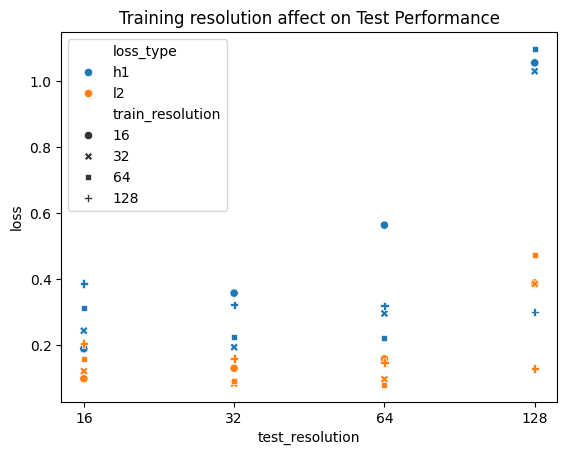

In [8]:
sns.scatterplot(
    data=df,
    x='test_resolution',
    y='loss',
    hue='loss_type',
    style='train_resolution',
)
plt.title('Training resolution affect on Test Performance')

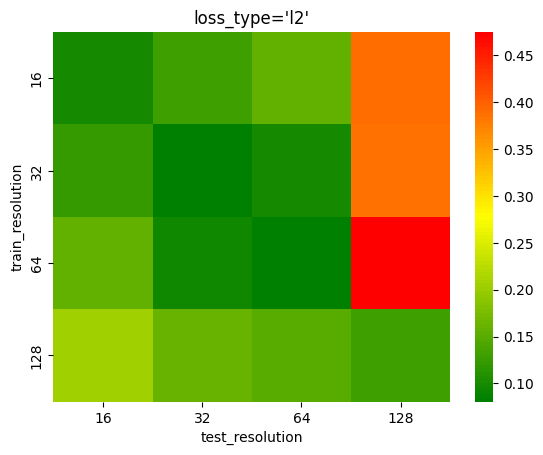

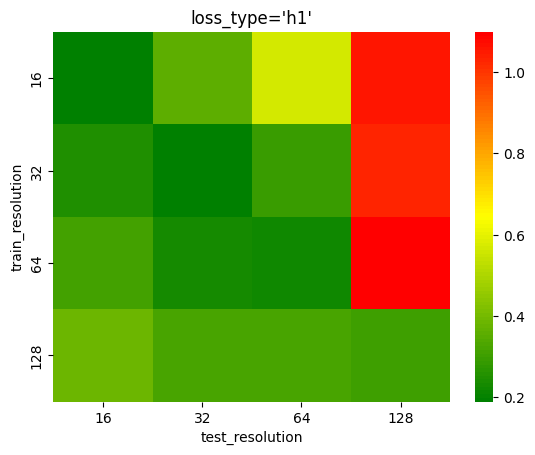

In [9]:
# Define colormap from green (high engagement) to red (low engagement)
cmap = mcolors.LinearSegmentedColormap.from_list(
    'green_red',
    ['green', 'yellow', 'red'],
    N=100,
)
for loss_type in ['l2', 'h1']:
    heat = df[df.loss_type == loss_type].pivot(
        index='train_resolution',
        columns='test_resolution',
        values='loss',
    )
    heat = heat.loc[:, ['16', '32', '64', '128']]
    sns.heatmap(heat, cmap=cmap)
    plt.title(f'{loss_type=}')
    plt.show()

# Compute loss on different Frequencies

In [37]:
for batch_16 in test_loaders[16]:  # resolution 16
    print(batch_16['y'].shape)  # bs, 1 time step, x_dim, y_dim

torch.Size([16, 1, 16, 16])
torch.Size([16, 1, 16, 16])
torch.Size([16, 1, 16, 16])
torch.Size([2, 1, 16, 16])


In [35]:
batch_16['x'].to(device).shape

torch.Size([16, 1, 16, 16])

In [38]:
model = model.to(device)

In [7]:
def frmse(
    pred,
    ground_truth,
):
    """Loss on diffrent frequencies."""
    batch_size = 16

    return batch_size